# Przewidywanie opadów w Australii

Szymon Męcina, Szymon Wydziałkiewicz, Michał Kaniewski

In [1]:
import numpy as np
import pandas as pd

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import MinMaxScaler

pd.options.display.float_format = "{:.2f}".format

In [2]:
df = pd.read_csv('Data/weatherAUS.csv')

df.Date=pd.to_datetime(df.Date).dt.date
df.insert(0, 'Month', pd.DatetimeIndex(df['Date']).month)
df=df.drop(columns='Date')

Po wczytaniu danych przechodzimy do ich analizy, na którą składa się opis wartości danych ilościowych, sprawdzenie liczby pól niewypełnionych oraz przedstawienie w jakiej korelacji pozostają atrybuty ramki danych.

In [3]:
df.describe()

,Month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,142193.00,141556.00,141871.00,140787.00,81350.00,74377.00,132923.00,140845.00,139563.00,140419.00,138583.00,128179.00,128212.00,88536.00,85099.00,141289.00,139467.00,142193.00
mean,6.40,12.19,23.23,2.35,5.47,7.62,39.98,14.00,18.64,68.84,51.48,1017.65,1015.26,4.44,4.50,16.99,21.69,2.36
std,3.43,6.40,7.12,8.47,4.19,3.78,13.59,8.89,8.80,19.05,20.80,7.11,7.04,2.89,2.72,6.49,6.94,8.48
min,1.00,-8.50,-4.80,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,977.10,0.00,0.00,-7.20,-5.40,0.00
25%,3.00,7.60,17.90,0.00,2.60,4.90,31.00,7.00,13.00,57.00,37.00,1012.90,1010.40,1.00,2.00,12.30,16.60,0.00
50%,6.00,12.00,22.60,0.00,4.80,8.50,39.00,13.00,19.00,70.00,52.00,1017.60,1015.20,5.00,5.00,16.70,21.10,0.00
75%,9.00,16.80,28.20,0.80,7.40,10.60,48.00,19.00,24.00,83.00,66.00,1022.40,1020.00,7.00,7.00,21.60,26.40,0.80
max,12.00,33.90,48.10,371.00,145.00,14.50,135.00,130.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.70,371.00


In [4]:
df.isna().sum()

Month                0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

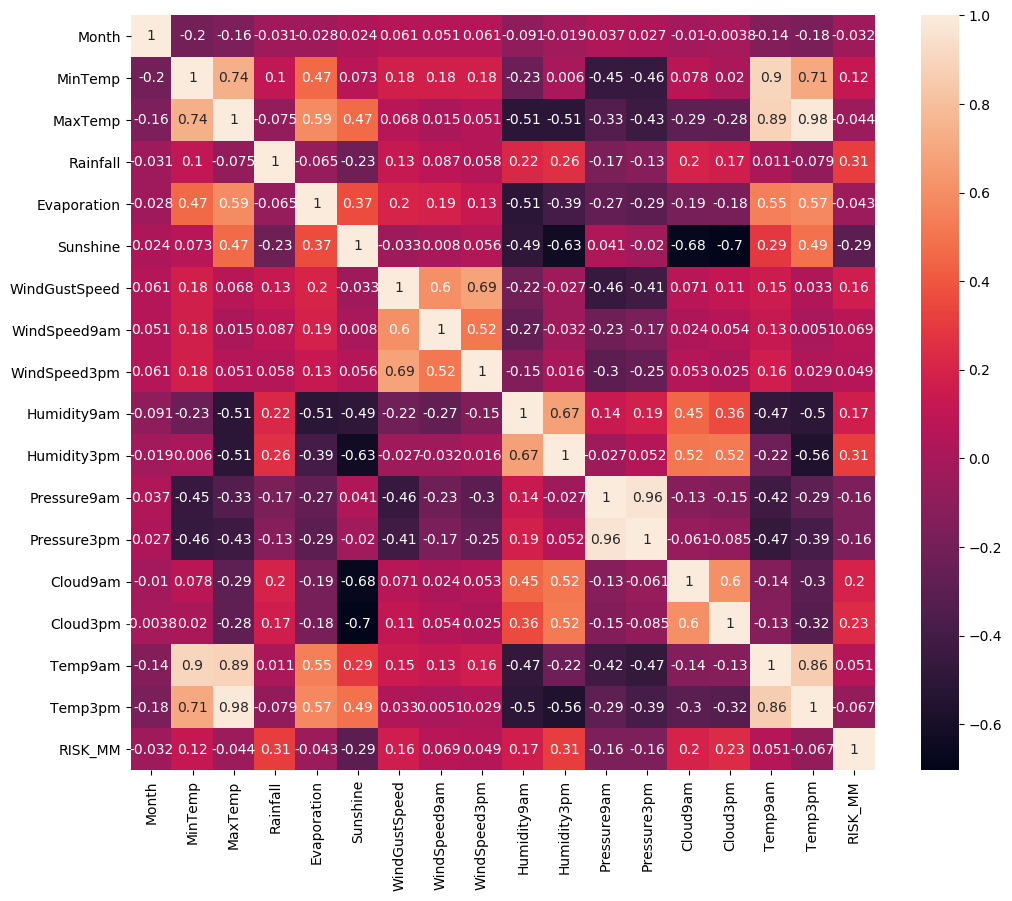

In [5]:
plt.figure(figsize=(12,10),dpi = 100)
sns.heatmap(df.corr(),annot = df.corr())

W naszym programie mamy zamiar jedynie oceniać pogodę w sposób binarny (deszcz będzie padał lub nie), dlatego atrybut ilościowy `RISK_MM` jest zbędny.

In [6]:
df = df.drop(columns=['RISK_MM'])

Jeszcze przed jakąkolwiek manipulacją danych przechodzimy do ich podziału na zbiór uczący oraz testowy, aby móc wyspecyfikować uzupełnianie danych wyłącznie w oparciu o zbiór uczący.

In [7]:
def split(df,proportion):
    x_train, x_test, y_train, y_test = train_test_split(
        df.iloc[:, 0:-1],df.iloc[:, -1].astype('category').cat.codes, test_size=proportion, random_state=0)
    return {"x_train":x_train, "x_test":x_test, "y_train":y_train, "y_test":y_test}

splitted_data = split(df, 0.3)

W pierwszym kroku wypełniamy ramkę używając danych z konkretnego miesiąca na przestrzeni wszystkich lat. Aby tego dokonać dzielimy kolumny na te o charakterze ilościowym oraz kategorycznym. Dla pierwszej grupy wykonujemy operację wyliczenia mediany dla danego miesiąca i aplikujemy go do pustych komórek z określonego miesiąca. W przypadku atrybutów kategorycznych proces wygląda identycznie, tylko zamiast wyliczania mediany stosowana jest moda.

In [8]:
columns_categ = [col for col in df.columns if df[col].dtypes == 'O']
columns_categ.remove('RainTomorrow')
columns_numeric = [col for col in df.columns if df[col].dtypes != 'O']
columns_numeric.remove('Month')

median_numeric = splitted_data['x_train'].groupby(splitted_data['x_train']['Month']).median()

for col in columns_numeric:
    for month in range(12):
        splitted_data['x_train'].loc[splitted_data['x_train'].Month == month].fillna(
            value=median_numeric.iloc[month][col], inplace=True)

for col in columns_categ:
    for month in range(1, 13):
        mode = splitted_data['x_train'].loc[splitted_data['x_train'].Month == month].loc[:, col].mode()[0]
        filled_column = splitted_data['x_train'].loc[:, col].loc[splitted_data['x_train'].Month == month].fillna(value=mode)
        splitted_data['x_train'].loc[:, col].loc[splitted_data['x_train'].Month == month] = filled_column

df=df.drop(columns='Month')
splitted_data['x_train'].isna().sum()

C:\Users\Szymon\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\Szymon\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Month                0
Location             0
MinTemp            419
MaxTemp            240
Rainfall           973
Evaporation      42589
Sunshine         47522
WindGustDir          0
WindGustSpeed     6444
WindDir9am           0
WindDir3pm           0
WindSpeed9am       940
WindSpeed3pm      1836
Humidity9am       1264
Humidity3pm       2535
Pressure9am       9879
Pressure3pm       9851
Cloud9am         37667
Cloud3pm         40007
Temp9am            639
Temp3pm           1905
RainToday            0
dtype: int64

Powyższa metoda nie jest jednak w stanie wypełnić wszystkich danych, dlatego dla pozostałych niewypełnionych komórek stosowana jest metoda identyczna, tylko w tym przypadku moda oraz mediana jest wyliczana dla całego okresu badawczego, bez podziału na miesiąc. Metoda ta skutecznie wypełnia wszystkie komórki.

In [9]:
for col in columns_numeric:
    col_median=splitted_data['x_train'][col].median()
    splitted_data['x_train'][col].fillna(col_median, inplace=True)   


for col in columns_numeric:
    col_median=splitted_data['x_test'][col].median()
    splitted_data['x_test'][col].fillna(col_median, inplace=True)  
    
    
for col in columns_categ:
    col_mode=splitted_data['x_train'][col].mode()[0]
    splitted_data['x_train'][col].fillna(col_mode, inplace=True)   


for col in columns_categ:
    col_mode=splitted_data['x_test'][col].mode()[0]
    splitted_data['x_test'][col].fillna(col_mode, inplace=True)  
    
splitted_data['x_train'].isna().sum()

Month            0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

Aby zamienić wartości kategoryczne na dane numeryczne, dokonujemy stworzenia dodatkowych kolumn, które przechowują informacje o kierunku wiatru i regionie w postaci parametrów logicznych.

In [10]:
splitted_data['x_test'] = pd.concat([splitted_data['x_test'][columns_numeric],
                     pd.get_dummies(splitted_data['x_test'].Location), 
                     pd.get_dummies(splitted_data['x_test'].WindGustDir),
                     pd.get_dummies(splitted_data['x_test'].WindDir9am),
                     pd.get_dummies(splitted_data['x_test'].WindDir3pm)], axis=1)

splitted_data['x_train'] = pd.concat([splitted_data['x_train'][columns_numeric],
                     pd.get_dummies(splitted_data['x_train'].Location), 
                     pd.get_dummies(splitted_data['x_train'].WindGustDir),
                     pd.get_dummies(splitted_data['x_train'].WindDir9am),
                     pd.get_dummies(splitted_data['x_train'].WindDir3pm)], axis=1)

Aby zastosować przetwarzane przez nas dane do wybranego modelu uczenia nadzorowanego, wykonujemy ich normalizację aby były traktowane przez model z odpowiednią wagą.

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(splitted_data['x_train'])
X_test = scaler.transform(splitted_data['x_test'])

splitted_data['x_train'] = pd.DataFrame(X_train, columns=[splitted_data['x_train'].columns])
splitted_data['x_test'] = pd.DataFrame(X_test, columns=[splitted_data['x_test'].columns])

Testując znane przez nas modele klasyfikacji oraz regresji postanowiliśmy zastosować metodę najbliższych prototypów, ponieważ jej wyniki okazały się najdokładniejsze.

In [12]:
model = NearestCentroid()
model.fit(splitted_data['x_train'], splitted_data['y_train'])
y_pred_test = model.predict(splitted_data['x_test'])

In [13]:
crosstab = pd.crosstab(y_pred_test, splitted_data['y_test'])
crosstab

col_0,0,1
row_0,,
0,23573,2216
1,9463,7406


Po zakończeniu procesu uczenia naszego modelu, przechodzimy do sprawdzenia efektywności prognozy pogody.

In [14]:
TN = crosstab[0][0]
FP = crosstab[0][1]
FN = crosstab[1][0]
TP = crosstab[1][1]

sensitivity = TP/(TP+FN)
specificity = TN/(FP+TN)
precision = TP/(TP+FP)
accuracy = (TP+TN)/(TN+FP+FN+TP)

print("sensitivity: ", sensitivity * 100)
print("specificity: ", specificity * 100)
print("precision: ", precision * 100)
print("accuracy: ", accuracy * 100)

sensitivity:  76.969445021825
specificity:  71.35549097953748
precision:  43.90301736913866
accuracy:  72.62178254958039
